In [ ]:
import pandas as pd 
import cv2                 
import numpy as np         
import os
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize

# Eksploratorna analiza podataka o PAPA testova vrata maternice

Podaci dolaze iz dva izvora - bolnice Herlev u Copenhagenu i SIPaKMeD-a - baze podataka posebno sastavljene za ovu svrhu. Sastoje se od niza slika pojedinačnih stanica vrata maternice, te cijelih slajdova takvih da se na svakoj slici nalaze brojne stanice odjednom. 

In [ ]:
dataset_path = '../input/pap-smear-datasets/'
print(dataset_path)
for item in os.listdir(dataset_path):
    print('  -- ' + item)
    for sub_item in os.listdir(dataset_path+item+'/'):
        print('    -- {} ({} files)'.format(sub_item, len(os.listdir(dataset_path + item + '/' + sub_item))))

../input/pap-smear-datasets/
  -- herlev_pap_smear
    -- normal_columnar (196 files)
    -- abnormal_severe_dysplastic (394 files)
    -- abnormal_light_dysplastic (364 files)
    -- normal_superficiel (148 files)
    -- normal_intermediate (140 files)
    -- abnormal_carcinoma_in_situ (300 files)
    -- abnormal_moderate_dysplastic (292 files)
  -- sipakmed_wsi_pap_smear
    -- abnormal_Koilocytotic (1888 files)
    -- benign_Metaplastic (1857 files)
    -- abnormal_Dyskeratotic (1849 files)
    -- normal_Parabasal (1682 files)
    -- normal_Superficial-Intermediate (1788 files)
  -- sipakmed_fci_pap_smear
    -- abnormal_Koilocytotic (2475 files)
    -- benign_Metaplastic (2379 files)
    -- abnormal_Dyskeratotic (2439 files)
    -- normal_Parabasal (2361 files)
    -- normal_Superficial_Intermediate (2493 files)


'Columnar', 'superficial' i 'intermediate' označavaju tip stanice, dok 'light', 'moderate' i 'severe dysplastic' označavaju stupanj abnormalnosti stanica. Podaci iz SIPaKMeD-a su podjeljeni na 'wsi' (whole slide images) - slike cijelih slajdova sa mnoštvom stanica na svakoj slici, te 'fci' (full cell images) - slike pojedinačnih stanica, te su dalje podjeljene na vrste stanice i tipove abnormalnosti. 

Pri klasifikaciji ćemo primjere vjerojatno razvrstavati samo na dvije klase - normalne i abnormalne, radi jednostavnosti izvedbe. Nadalje, slike cijelih slajdova ćemo večinom ignorirati, te ćemo se baviti klasifikacijom pojedinačnih stanica. Promotrimo broj primjera u svakom skupu:

In [ ]:
dataset_path = '../input/pap-smear-datasets/'
herlev = dataset_path + 'herlev_pap_smear/'
sipakmed = dataset_path + 'sipakmed_fci_pap_smear/'
herlev_normal = 0
herlev_abnormal = 0
sipakmed_normal = 0
sipakmed_abnormal = 0
sipakmed_benign = 0

for item in os.listdir(herlev):
    if item[:3] == 'abn': herlev_abnormal = int(herlev_abnormal + len(os.listdir(herlev + item)) / 2)
    elif item[:3] == 'nor': herlev_normal = int(herlev_normal + len(os.listdir(herlev + item)) / 2)
for item in os.listdir(sipakmed):
    if item[:3] == 'abn': sipakmed_abnormal = int(sipakmed_abnormal + len(os.listdir(sipakmed + item)) / 3)
    elif item[:3] == 'nor': sipakmed_normal = int(sipakmed_normal + len(os.listdir(sipakmed + item)) / 3)
    elif item[:3] == 'ben': sipakmed_benign = int(sipakmed_benign + len(os.listdir(sipakmed + item)) / 3)
    
print(f'herlev_normal: {herlev_normal}')
print(f'herlev_abnormal: {herlev_abnormal}')
print(f'sipakmed_normal: {sipakmed_normal}')
print(f'sipakmed_abnormal: {sipakmed_abnormal}')
print(f'sipakmed_benign: {sipakmed_benign}')
print(f'total normal: {herlev_normal + sipakmed_normal}')
print(f'total abnormal: {herlev_abnormal + sipakmed_abnormal}')

herlev_normal: 242
herlev_abnormal: 675
sipakmed_normal: 1618
sipakmed_abnormal: 1638
sipakmed_benign: 793
total normal: 1860
total abnormal: 2313


Vidimo da imamo relativno malen broj podataka iz bolnice Herlev, te su još uz to loše balansirani (puno više primjera abnormalnih stanica nego normalnih). Stoga ćemo za bilo kakav trening modela strojnog učenja morati kombinirati primjere iz Herlev i SIPaKMeD baza, a možda ćak i umjetno proširiti te baze nekim transformacijama slika (zrcaljenjem, rotacijom, smicanjem i sličnim). 

## Podaci iz bolnice Herlev

Podaci iz bolnice Herlev podjeljeni su na sedam skupina - 4 vrste abnormalnih (pre-malignih) stanica i tri vrste normalnih stanica. Podaci u ovom skupu dolaze i sa segmentiranim verzijama slika, pri čemu je svaka slika podjeljena na jezgru stanice, citoplazmu te područje izvan stanice. Na sljedećoj slici je uzorak nekih od slika u pitanju te njihovih segmentiranih inačica:


In [ ]:
Herlev = "../input/pap-smear-datasets/herlev_pap_smear/"
Sipakmed_fci = "../input/pap-smear-datasets/sipakmed_fci_pap_smear/"
Sipakmed_wsi = "../input/pap-smear-datasets/sipakmed_wsi_pap_smear/"
list_H = os.listdir(Herlev)
list_H.sort(reverse=True)
list_S1 = os.listdir(Sipakmed_fci)
list_S2 = os.listdir(Sipakmed_wsi)

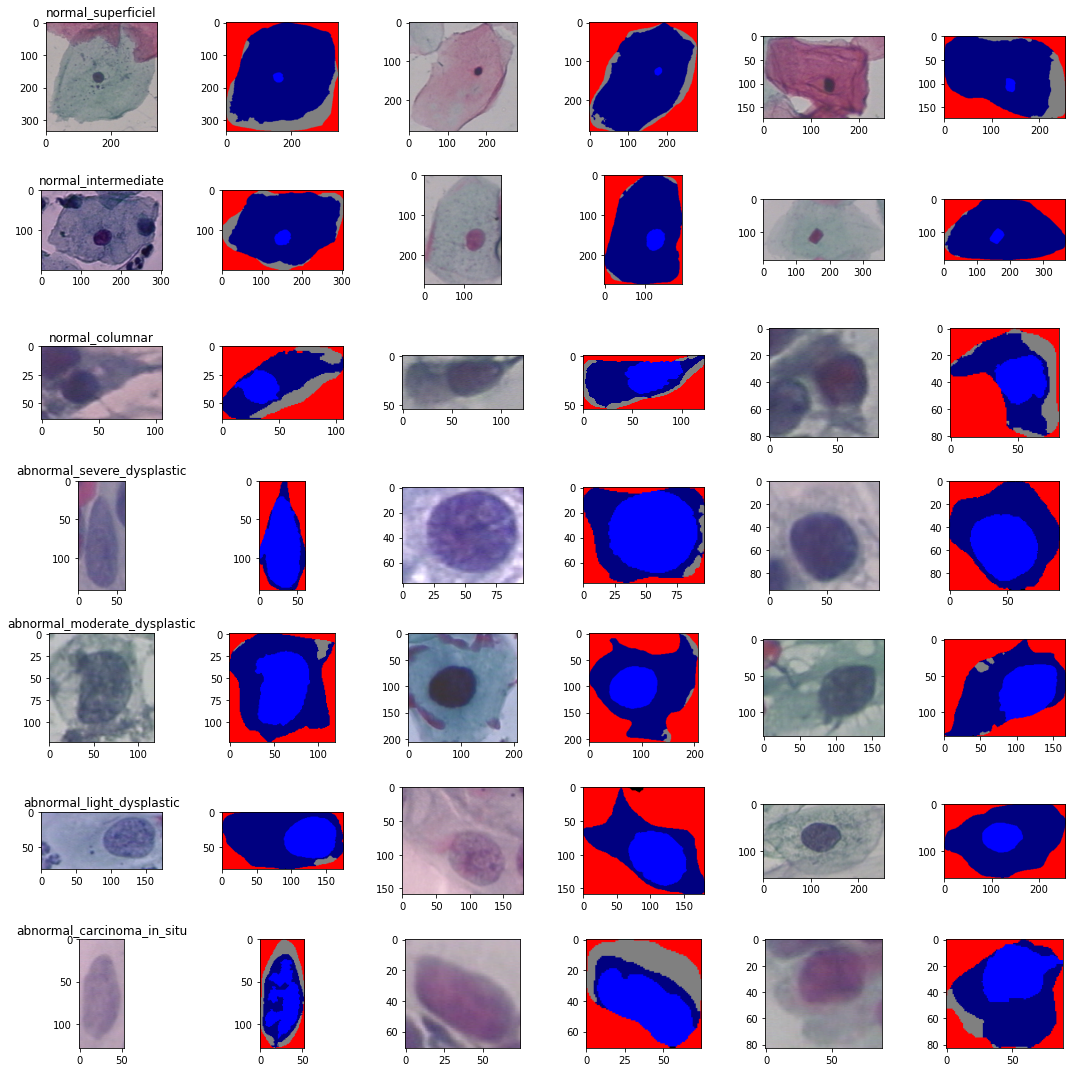

In [ ]:
fig, axes = plt.subplots(7, 6, figsize=(15,15))
for i in range(7):
    axes[i,0].set_title(list_H[i])
    for j in range(3):
        img_list = os.listdir(Herlev+list_H[i])
        img_list = [item for item in img_list if item[-5] != 'd']
        img_name = '{}{}/{}'.format(Herlev, list_H[i], img_list[j*2-1])
        img_d_name = img_name[:-4]+'-d'+img_name[-4:].lower()
        img = plt.imread(img_name)
        img_d = plt.imread(img_d_name)
        axes[i, 2*j].imshow(img)
        axes[i, 2*j+1].imshow(img_d)
plt.tight_layout()
plt.show()

Odmah vidimo ta je karakteristika abnormalnih stanica vrlo velika jezgra u odnosu na ostatak stanice - u nekim primjerima, ona zauzima gotovo cijelu stanicu. Možemo zaključiti sljedeće: kada bismo mogli automatizirati segmentaciju prikazanu gore (naučiti računalo da razlikuje jezgru od citoplazme), možda je dovoljno usporediti njihove veličine da bismo dobili dobru ideju o tome je li neka stanica abnormalna ili nije. S obzirom da je to problem binarne klasifikacije na osnovu jedne numeričke karakteristike, on je rješiv jednostavnom logističkom regresijom. 

### Segmentacija stanica

Ako je gornji zaključak točan, glavni problem kojeg treba riješiti je segmentacija. Na slikama odmah primjećujemo da je jezgra puno tamnije boje od citoplazme, koja je pak tamnija od područja izvan stanice. Da bismo pomogli računalu da razazna razliku između ta tri područja, možemo se poigrati sa kontrastom na slikama kako bismo naglasili razliku u jačini boje. 

U sljedećem primjeru na slike po elementima djelujemo sa funkcijom 

$$
f(x) = \max(\min(kx+l), 1), 0)\\
k > 0, l < 0
$$
koja na segmentu $[0, 1]$ izgleda ovako:

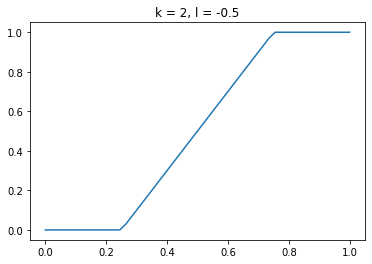

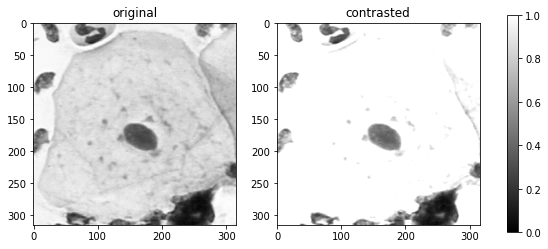

In [ ]:
import matplotlib.cm as cm

# Contrast manipulator function
def contrast(x, a, b):
    k = 1/(b-a)
    l = -k*a
    return max(min(x*k+l, 1), 0)

contrast_v = np.vectorize(contrast, otypes=[float])

# Effect visualization
x = np.linspace(0,1)
plt.plot(x, contrast_v(x, 0.25, 0.75))
plt.title('k = 2, l = -0.5')
# plt.plot(x, x, '--')
plt.show()

# Example using an image
img = plt.imread(Herlev+'/normal_intermediate/153955676-153955721-001.BMP')
img_gs = img.sum(axis=2)       # Convert to grayscale
img_gs = img_gs/img_gs.max()   # Normalize
img_contrasted = contrast_v(img_gs, 0.2, 0.8)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
ax1.imshow(img_gs, cmap='gray')
ax1.set_title('original')
ax2.imshow(img_contrasted, cmap='gray')
ax2.set_title('contrasted')
fig.colorbar(mappable = cm.ScalarMappable(cmap='gray'), ax=[ax1,ax2])
fig.show()

Sada možemo primjeniti funkciju na gornji primjer sa više različitih vrijednosti za $k$ i $l$ kako bismo vidjeli kako će se rezultat ponašati. $a$ i $b$ su vrijednosti u kojima pravac $kx+l$ sjeće pravce $y=0$ i $y=1$, respektivno 

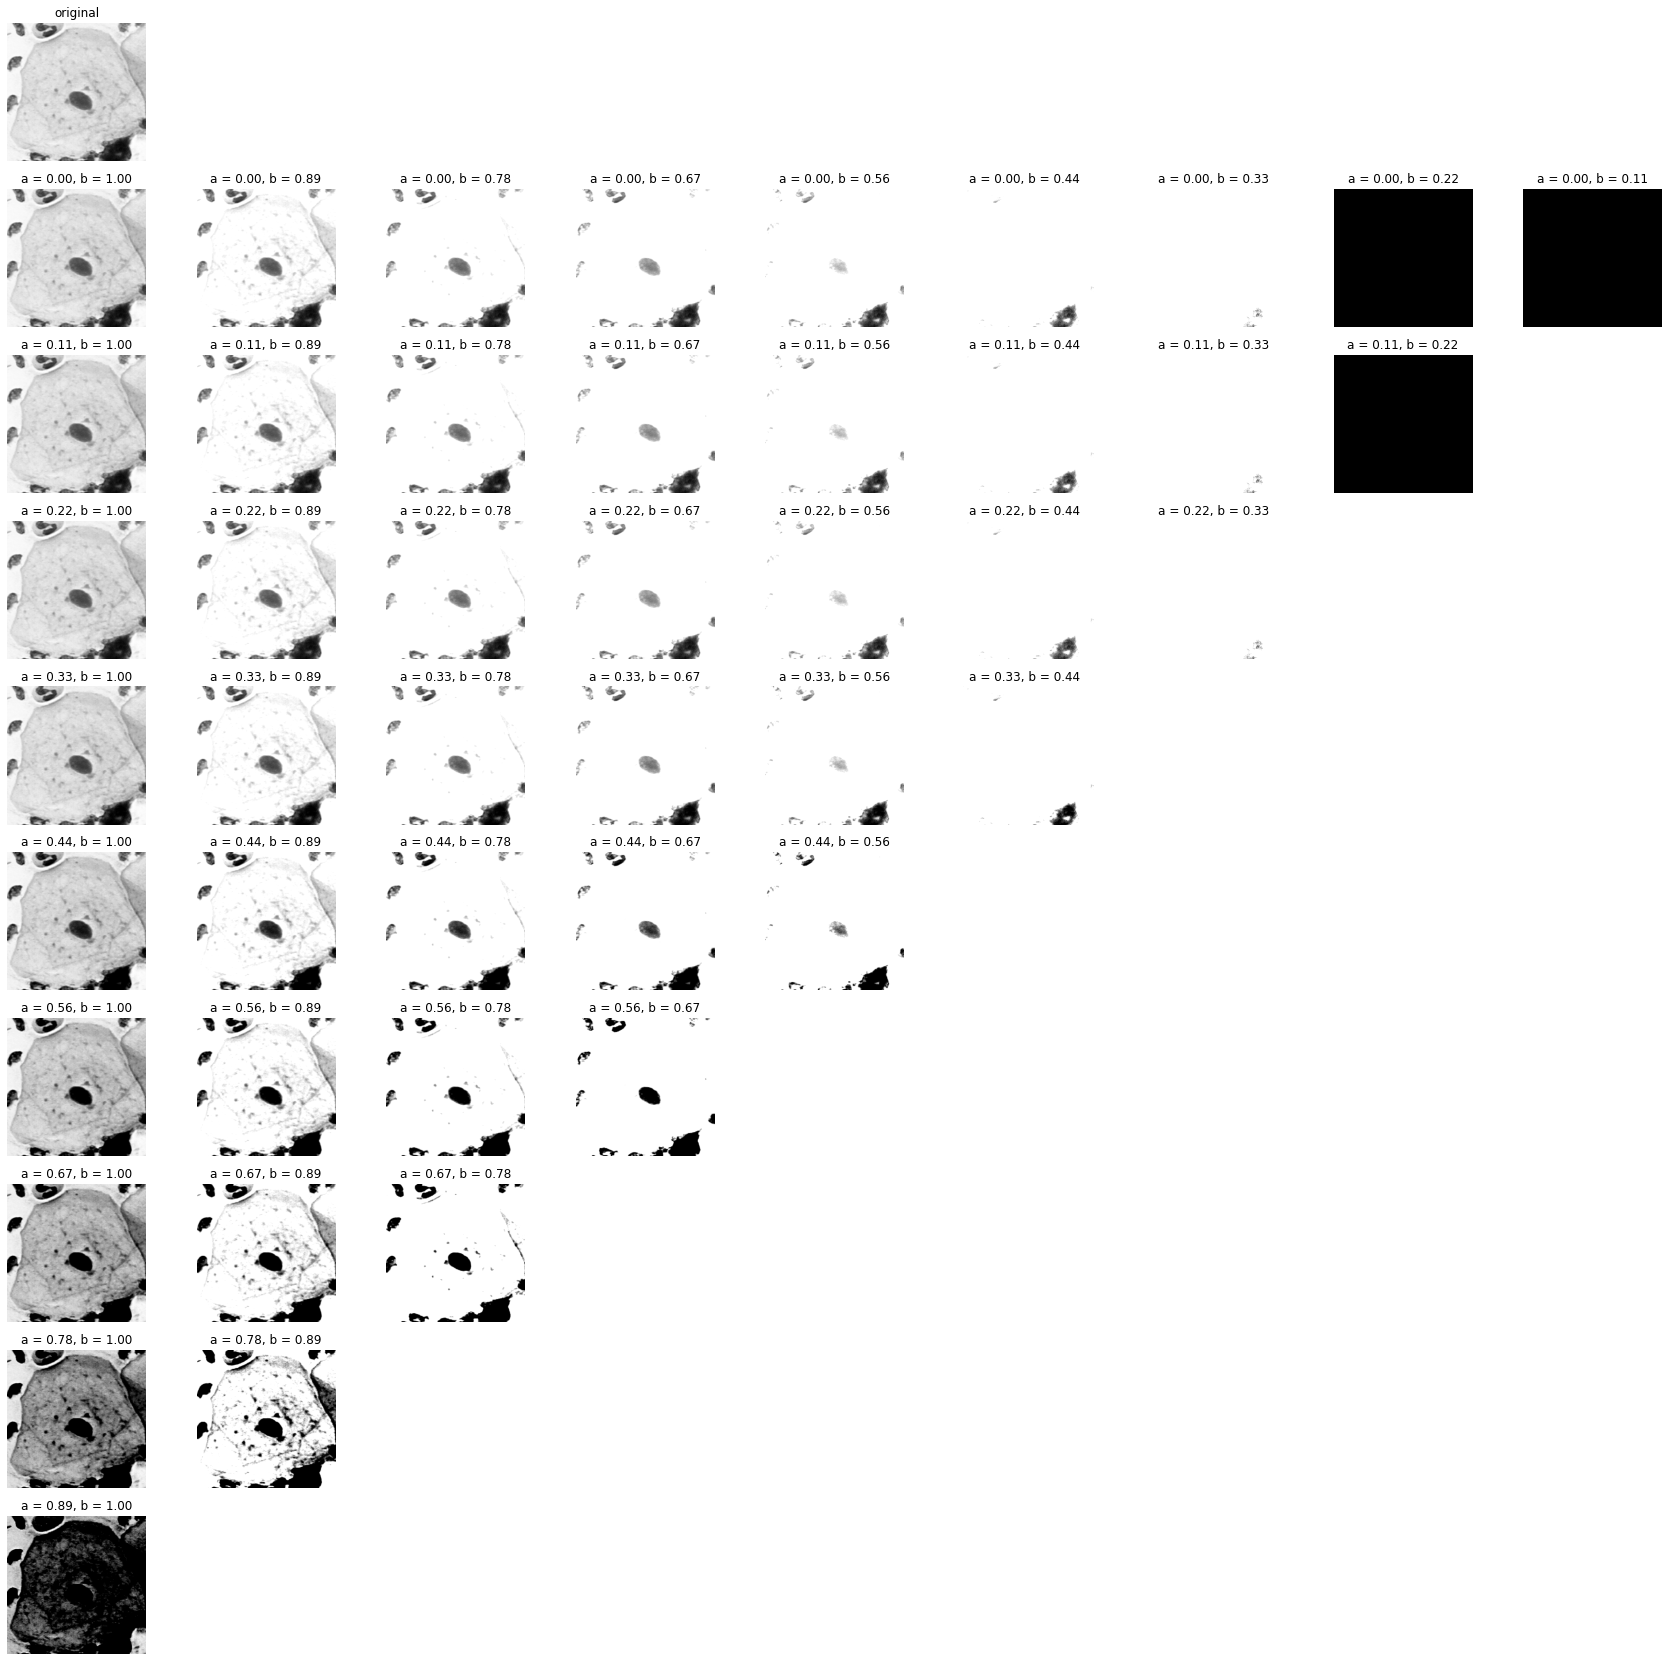

In [ ]:
a_space = np.linspace(0, 1, 10)
b_space = np.linspace(0, 1, 10)

img = plt.imread(Herlev+'/normal_intermediate/153955676-153955721-001.BMP')
img_gs = img.sum(axis=2)       # Convert to grayscale
img_gs = img_gs/img_gs.max()   # Normalize

fig, ax = plt.subplots(len(a_space), len(b_space)-1, figsize = (30,30))
ax[0,0].imshow(img_gs, cmap='gray')
ax[0,0].set_title('original')
i = 1
for a in a_space:
    j = 0
    for b in b_space:
        if b > a:
            ax_current = ax[i, 9-i-j]
            ax_current.imshow(contrast_v(img_gs, a, b), cmap='gray')
            ax_current.set_title('a = {:.2f}, b = {:.2f}'.format(a, b))
            j = j+1
    i = i+1

for axis in ax.flat: axis.axis('off')
fig.show()

Na kraju četvrtog reda odozdo vidimo da se jezgra vrlo dobro ističe od svojeg okruženja - ona ostaje sasvim crna, dok je citoplazma oko nje potpuno pobjelila. U zadnjem redu vidimo da je cijela citoplazma vrlo tamna, dok je područje oko stanice i dalje vrlo svjetlo. Vjerujemo da ćemo uz malo finiju manipulaciju ovog tipa vrlo lako moći segmentirati stanice. Isto tako možemo na sliku primjeniti neke rudimentarne konvolucije (npr. detekcija horizontalnih i vertikalnih rubova) i vidjeti hoće li to pomoći pri segmentaciji: 

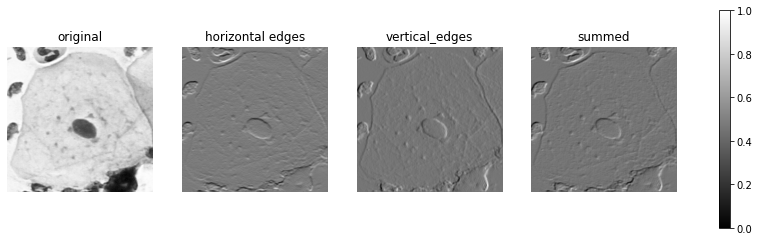

In [ ]:
img = plt.imread(Herlev+'/normal_intermediate/153955676-153955721-001.BMP')
img_gs = img.sum(axis=2)       # Convert to grayscale
img_gs = img_gs/img_gs.max()   # Normalize

# Apply a 3x3 convolution to an m-by-n matrix
def convolve(matrix, pattern):
    [m, n] = matrix.shape
    output = np.zeros((m-1, n-1))
    for i in range(1, m-1):
        for j in range(1, n-1):
            output[i-1,j-1] = (matrix[i-1:i+2,j-1:j+2]*pattern).sum()
    return output

pattern_horizontal = np.array([[-1, -1, -1],
                               [0, 0, 0],
                               [1, 1, 1]])/6

pattern_vertical = np.array([[-1, 0, 1],
                             [-1, 0, 1],
                             [-1, 0, 1]])/6

c1 = convolve(img_gs, pattern_horizontal)
c2 = convolve(img_gs, pattern_vertical)

fix, ax = plt.subplots(1, 4, figsize = (15, 4))
ax[0].imshow(img_gs, cmap = 'gray')
ax[0].set_title('original')
ax[1].imshow(c1, cmap = 'gray')
ax[1].set_title('horizontal edges')
ax[2].imshow(c2, cmap = 'gray')
ax[2].set_title('vertical edges')
ax[3].imshow(c1+c2, cmap = 'gray')
ax[3].set_title('summed')
fig.colorbar(mappable = cm.ScalarMappable(cmap='gray'), ax=ax)
for axis in ax.flat: axis.axis('off')

fig.show()


## SIPaKMeD baza (pojedinačne stanice)

Uz svaku sliku u ovoj bazi dolaze još dvije .dat datoteke - CSV datoteke koje opisuju poligone koji okružuju jezgru i citoplazmu stanice na slici. Na primjer:

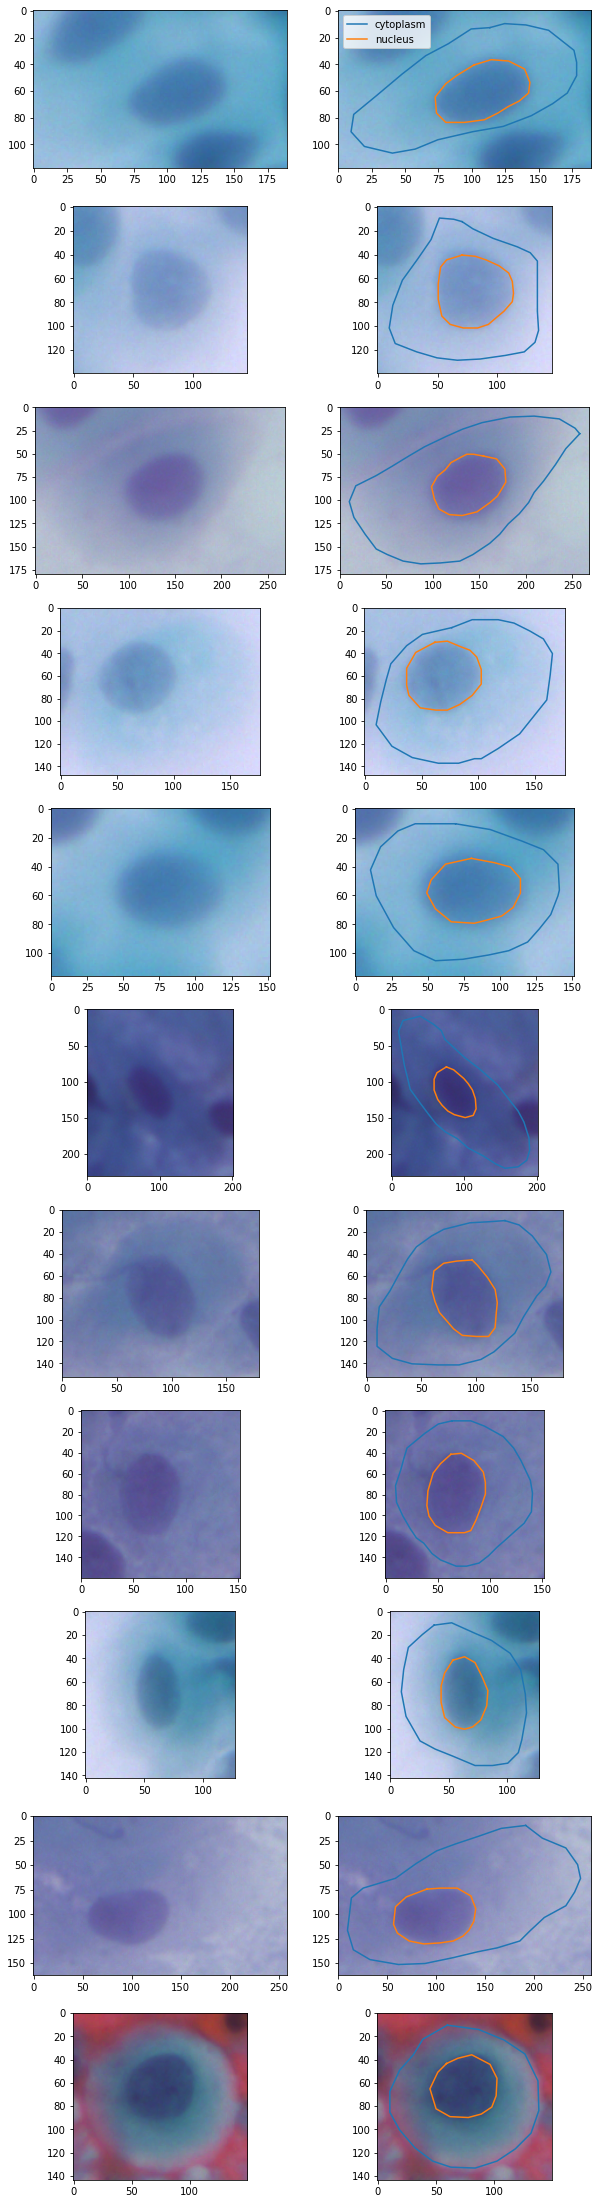

In [ ]:
import csv

path = '../input/pap-smear-datasets/sipakmed_fci_pap_smear/normal_Parabasal/'

i = 0
images = []
cyt_paths = []
nuc_paths = []
for img_name in [item for item in os.listdir(path) if item[-4:] == '.bmp']:
    designation = img_name[:-4]
    
    images.append(plt.imread(path + designation + '.bmp'))

    cyt_path = []
    with open(path + designation + '_cyt.dat') as f:
        r = csv.reader(f, delimiter = ',')
        for row in r: cyt_path.append([float(row[0]), float(row[1])])
    cyt_paths.append(np.array(cyt_path))
    
    nuc_path = []
    with open(path + designation + '_nuc.dat') as f:
        r = csv.reader(f, delimiter = ',')
        for row in r: nuc_path.append([float(row[0]), float(row[1])])
    nuc_paths.append(np.array(nuc_path))
    i = i+1
    if i>10: break
    
fig, ax = plt.subplots(len(images), 2, figsize = (10,40))
for i, [img, cyt, nuc] in enumerate(zip(images, cyt_paths, nuc_paths)):
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(img)
    ax[i, 1].plot(cyt[:,0], cyt[:,1])
    ax[i, 1].plot(nuc[:,0], nuc[:,1])
ax[0,1].legend(['cytoplasm', 'nucleus'])
fig.show()

Vidimo da je u ovom slucaju znacajno teze razaznati granicu izmedu citoplazme i područja izvan stanica, čak i ljudskom oku, pa će biti vrlo teško konstruirati preciznu automatsku segmentaciju. 